TODO

1. Get data on all-stars
2. Get data on groupings of teams...(contender, mid-tier, rebuilding) (>50 wins, >40 wins, rest)??
3. Get team salary data



In [2]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math

In [3]:
##LOADING 2018 DATA (2017-2018 NBA Season)

team_per100 = pd.read_csv('../Data/Team/2018/team_per100.csv')
opp_per100 = pd.read_csv('../Data/Team/2018/opp_per100.csv')
misc = pd.read_csv('../Data/Team/2018/misc.csv', skiprows = 1)

shooting_col_names = ['Rk', 'Team', 'G', 'MP', 'FG%', 'Dist.',
                      'Pct_FGA_by_dist_2P' , 'Pct_FGA_by_dist_0-3', 'Pct_FGA_by_dist_3-10', 'Pct_FGA_by_dist_10-16', 'Pct_FGA_by_dist_16-3pt', 'Pct_FGA_by_dist_3P',
                     'FGP_by_dist_2P' , 'FGP_by_dist_0-3', 'FGP_by_dist_3-10', 'FGP_by_dist_10-16', 'FGP_by_dist_16-3pt', 'FGP_by_dist_3P',
                     '2FG_%assisted','2FG_dunks_%FGA','2FG_dunks_made','2FG_layups_%FGA','2FG_layups_made',
                     '3FG_%assisted','3FG_corner_%3PA','3FG_corner_3P%','3FG_heaves_att','3FG_heaves_made']

team_shooting = pd.read_csv('../Data/Team/2018/team_shooting.csv', names = shooting_col_names, skiprows = 3)
opp_shooting = pd.read_csv('../Data/Team/2018/opp_shooting.csv', names = shooting_col_names, skiprows = 2)

In [4]:
## Selecting Specific Columns
team_per100_select = team_per100[['Team' ,'MP', '3PA', '3P%', '2PA', '2P%', 'FTA', 'FT%', 'ORB', 'DRB','AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]
opp_per100_select = opp_per100[['Team' ,'MP', '3PA', '3P%', '2PA', '2P%', 'FTA', 'FT%', 'ORB', 'DRB','AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]

team_shooting_select = team_shooting[['Team', 'Dist.', 'Pct_FGA_by_dist_2P','Pct_FGA_by_dist_0-3','Pct_FGA_by_dist_3-10','Pct_FGA_by_dist_10-16','Pct_FGA_by_dist_16-3pt','Pct_FGA_by_dist_3P',
                                     'FGP_by_dist_2P','FGP_by_dist_0-3','FGP_by_dist_3-10','FGP_by_dist_10-16','FGP_by_dist_16-3pt','FGP_by_dist_3P','3FG_%assisted','3FG_corner_%3PA','3FG_corner_3P%']]
opp_shooting_select = opp_shooting[['Team', 'Dist.', 'Pct_FGA_by_dist_2P','Pct_FGA_by_dist_0-3','Pct_FGA_by_dist_3-10','Pct_FGA_by_dist_10-16','Pct_FGA_by_dist_16-3pt','Pct_FGA_by_dist_3P',
                                     'FGP_by_dist_2P','FGP_by_dist_0-3','FGP_by_dist_3-10','FGP_by_dist_10-16','FGP_by_dist_16-3pt','FGP_by_dist_3P','3FG_%assisted','3FG_corner_%3PA','3FG_corner_3P%']]

#duplicate TOV rates, must remove
misc_select = misc.drop(['Rk','SOS', 'SRS','Arena', 'TOV%', 'TOV%.1'], axis=1)





In [5]:
## Renaming OPP columns to ahve prefix 'opp_'
opp_per100_select = opp_per100_select.add_prefix('opp_')
opp_shooting_select = opp_shooting_select.add_prefix('opp_')

#Rename Misc columns eFG%.1 and FT/FGA.1 to have prefix opp
misc_select.rename(columns={'eFG%.1':'opp_eFG%'}, inplace=True)
misc_select.rename(columns={'FT/FGA.1':'opp_FT/FGA'}, inplace=True)

In [6]:
## Creating Joined Table

j1 = team_per100_select.merge(opp_per100_select, left_on = 'Team', right_on = 'opp_Team', how = 'left')
j2 = j1.merge(team_shooting_select, on='Team', how = 'left')
j3 = j2.merge(opp_shooting_select, left_on = 'Team', right_on = 'opp_Team', how = 'left')
j4 = j3.merge(misc_select, on='Team', how = 'left')

In [7]:
## Creating flag for Playoff team
j4['Playoff'] = j4.apply(lambda row: 1 if '*' in row.Team else 0, axis=1)


#Creating categorical for Contender, Mid-Tier, Rebuilding
def tier (row):
    if row['W'] >= 50 :
        return 'Contender'
    elif row['W'] >= 38:
        return 'Mid-Tier'
    else:
        return 'Rebuilding'
    
j4['Tier'] = j4.apply(lambda row: tier(row), axis = 1)
    
#j4['Tier'] = j4.apply(lambda row: 'Contender' if row.W>=50  else if row.W>=40 'Mid-Tier' else 'Rebuilding', axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113d8f8d0>,
      dtype=object)

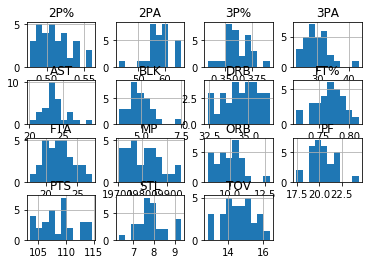

In [7]:
team_per100_select.hist()

In [8]:
#Send correlation to .xlsx to manually select variables that make sense and are not too multicollinear
j4.corr().to_csv('correlation_table.csv')

In [ ]:
#Sorting table by different values
#j4.sort_values(by='Tier', axis = 0, ascending = False)

In [ ]:
#Plot Wins by Playoff and Non Playoff
# playoff = j4.loc[j4['Playoff'] == 1]
# non_playoff = j4.loc[j4['Playoff'] == 0]

# sns.distplot(j4[['W']], color="y")
# sns.distplot(playoff[['W']], hist=False, color="g")
# sns.distplot(non_playoff[['W']], hist=False, color="r")


In [ ]:
#Wins by Tier and Playoff
plt.figure()
sns.boxplot(x="Tier", y="W", data=j4)
plt.figure()
sns.boxplot(x="Playoff", y="W", data=j4)

In [ ]:
#j4.select_dtypes(exclude='object')

In [ ]:
for i in j4.select_dtypes(exclude='object'):
    plt.figure()
    sns.boxplot(x="Tier", y=i, data=j4)


In [ ]:
for i in j4.select_dtypes(exclude='object'):
    plt.figure()
    sns.boxplot(x="Playoff", y=i, data=j4)

In [ ]:
#Correlation Plot

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = j4

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
#Summary of full table
#Calculate a normalized standard dev = std/mean of column

summary = j4.describe().T
sigma = np.array(summary[['std']])
mu = np.array(summary[['mean']])
summary['norm_std'] = np.absolute(sigma/mu)
summary.sort_values(by='norm_std', axis = 0, ascending = False)

In [15]:
# ADD TEAM ABBREVIATIONS

tm_abrv = np.array([['ATL','Atlanta Hawks'],
['BKN','Brooklyn Nets'],
['BOS','Boston Celtics'],
['CHA','Charlotte Hornets'],
['CHI','Chicago Bulls'],
['CLE','Cleveland Cavaliers'],
['DAL','Dallas Mavericks'],
['DEN','Denver Nuggets'],
['DET','Detroit Pistons'],
['GSW','Golden State Warriors'],
['HOU','Houston Rockets'],
['IND','Indiana Pacers'],
['LAC','Los Angeles Clippers'],
['LAL','Los Angeles Lakers'],
['MEM','Memphis Grizzlies'],
['MIA','Miami Heat'],
['MIL','Milwaukee Bucks'],
['MIN','Minnesota Timberwolves'],
['NOP','New Orleans Pelicans'],
['NYK','New York Knicks'],
['OKC','Oklahoma City Thunder'],
['ORL','Orlando Magic'],
['PHI','Philadelphia 76ers'],
['PHX','Phoenix Suns'],
['POR','Portland Trail Blazers'],
['SAC','Sacramento Kings'],
['SAS','San Antonio Spurs'],
['TOR','Toronto Raptors'],
['UTA','Utah Jazz'],
['WAS','Washington Wizards']])

tm_abrv = pd.DataFrame(tm_abrv)

#remove * from team
j4['Team'] = j4.apply(lambda row: row.Team.split('*')[0] if '*' in row.Team else row.Team , axis=1)

j5 = j4.merge(tm_abrv, left_on = 'Team', right_on = 1)



In [ ]:
j4.to_csv('teams_cleaned.csv')

In [16]:
j5.head()

,Team,MP,3PA,3P%,2PA,2P%,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,opp_Team_x,opp_MP,opp_3PA,opp_3P%,opp_2PA,opp_2P%,opp_FTA,opp_FT%,opp_ORB,opp_DRB,opp_AST,opp_STL,opp_BLK,opp_TOV,opp_PF,opp_PTS,Dist.,Pct_FGA_by_dist_2P,Pct_FGA_by_dist_0-3,Pct_FGA_by_dist_3-10,Pct_FGA_by_dist_10-16,Pct_FGA_by_dist_16-3pt,Pct_FGA_by_dist_3P,FGP_by_dist_2P,FGP_by_dist_0-3,FGP_by_dist_3-10,FGP_by_dist_10-16,FGP_by_dist_16-3pt,FGP_by_dist_3P,3FG_%assisted,3FG_corner_%3PA,3FG_corner_3P%,opp_Team_y,opp_Dist.,opp_Pct_FGA_by_dist_2P,opp_Pct_FGA_by_dist_0-3,opp_Pct_FGA_by_dist_3-10,opp_Pct_FGA_by_dist_10-16,opp_Pct_FGA_by_dist_16-3pt,opp_Pct_FGA_by_dist_3P,opp_FGP_by_dist_2P,opp_FGP_by_dist_0-3,opp_FGP_by_dist_3-10,opp_FGP_by_dist_10-16,opp_FGP_by_dist_16-3pt,opp_FGP_by_dist_3P,opp_3FG_%assisted,opp_3FG_corner_%3PA,opp_3FG_corner_3P%,Age,W,L,PW,PL,MOV,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,ORB%,FT/FGA,opp_eFG%,DRB%,opp_FT/FGA,Attend.,Attend./G,Playoff,Tier,0,1
0,Golden State Warriors,19730,28.9,0.391,56.3,0.560,20.4,0.815,8.4,35.1,29.3,8.0,7.5,15.5,19.6,113.6,Golden State Warriors*,19730,29.2,0.357,60.9,0.490,22.1,0.758,10.9,31.7,23.6,8.8,3.7,14.4,18.5,107.6,14.0,0.661,0.267,0.111,0.139,0.144,0.339,0.560,0.708,0.424,0.485,0.463,0.391,0.801,0.158,0.405,Golden State Warriors*,12.9,.676,.278,.166,.112,.120,.324,.490,.652,.380,.390,.359,.357,.802,.189,.378,28.8,58.0,24.0,56,26,5.98,113.6,107.6,6.0,99.6,0.239,0.339,0.603,0.569,21.0,0.195,0.504,76.3,0.186,803436,19596,1,Contender,GSW,Golden State Warriors
1,Houston Rockets,19755,43.2,0.362,42.8,0.558,25.7,0.781,9.2,35.2,22.0,8.7,4.9,14.1,19.9,114.7,Houston Rockets*,19755,29.5,0.351,57.9,0.519,20.0,0.746,8.8,34.1,22.9,7.6,4.5,14.9,20.8,106.1,15.0,0.498,0.288,0.103,0.062,0.044,0.502,0.558,0.669,0.369,0.454,0.430,0.362,0.689,0.227,0.401,Houston Rockets*,12.8,.663,.304,.157,.097,.104,.337,.519,.670,.412,.396,.358,.351,.802,.214,.380,29.8,65.0,17.0,61,21,8.48,114.7,106.1,8.6,97.6,0.298,0.502,0.590,0.551,21.3,0.233,0.521,79.9,0.171,732722,17871,1,Contender,HOU,Houston Rockets
2,New Orleans Pelicans,19955,27.7,0.362,59.0,0.540,20.5,0.772,8.5,35.0,26.3,7.9,5.8,14.6,18.8,109.6,New Orleans Pelicans*,19955,30.0,0.355,60.2,0.503,20.1,0.784,10.6,34.0,23.3,8.0,4.1,14.2,20.0,108.3,12.5,0.681,0.295,0.179,0.099,0.109,0.319,0.540,0.667,0.475,0.441,0.396,0.362,0.876,0.233,0.399,New Orleans Pelicans*,13.3,.667,.278,.155,.109,.125,.333,.503,.650,.410,.399,.385,.355,.833,.201,.379,27.6,48.0,34.0,44,38,1.30,109.6,108.3,1.3,100.5,0.237,0.319,0.573,0.541,20.0,0.183,0.513,76.7,0.175,673920,16437,1,Mid-Tier,NOP,New Orleans Pelicans
3,Toronto Raptors,19830,33.6,0.358,55.5,0.541,22.2,0.794,9.9,34.9,24.8,7.8,6.2,13.6,22.2,113.8,Toronto Raptors*,19830,25.4,0.357,61.8,0.486,24.1,0.767,10.0,33.2,22.2,7.3,5.0,14.6,20.3,105.9,13.2,0.623,0.291,0.160,0.098,0.074,0.377,0.541,0.681,0.414,0.428,0.419,0.358,0.816,0.243,0.396,Toronto Raptors*,12.2,.708,.298,.177,.121,.112,.292,.486,.617,.359,.432,.401,.357,.813,.196,.363,25.8,59.0,23.0,60,22,7.78,113.8,105.9,7.9,97.4,0.250,0.377,0.575,0.539,23.0,0.198,0.501,77.7,0.212,813431,19840,1,Contender,TOR,Toronto Raptors
4,Cleveland Cavaliers,19730,32.7,0.372,53.6,0.540,23.7,0.779,8.6,34.3,23.8,7.2,3.9,14.0,18.9,112.9,Cleveland Cavaliers*,19730,32.2,0.368,57.6,0.533,19.7,0.756,10.1,34.3,26.3,7.6,4.2,13.7,21.1,111.9,13.8,0.621,0.297,0.113,0.092,0.119,0.379,0.540,0.706,0.368,0.413,0.387,0.372,0.819,0.252,0.417,Cleveland Cavaliers*,13.4,.641,.299,.132,.104,.107,.359,.533,.672,.399,.429,.409,.368,.832,.213,.446,30.6,50.0,32.0,43,39,0.94,112.9,111.9,1.0,98.0,0.275,0.379,0.584,0.547,20.1,0.214,0.540,77.3,0.166,843042,20562,1,Contender,CLE,Cleveland Cavaliers


In [11]:
'hi*'.split('*')[0]

'hi'